<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch03_CH01_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정보추출
## Bi-LSTM CRF
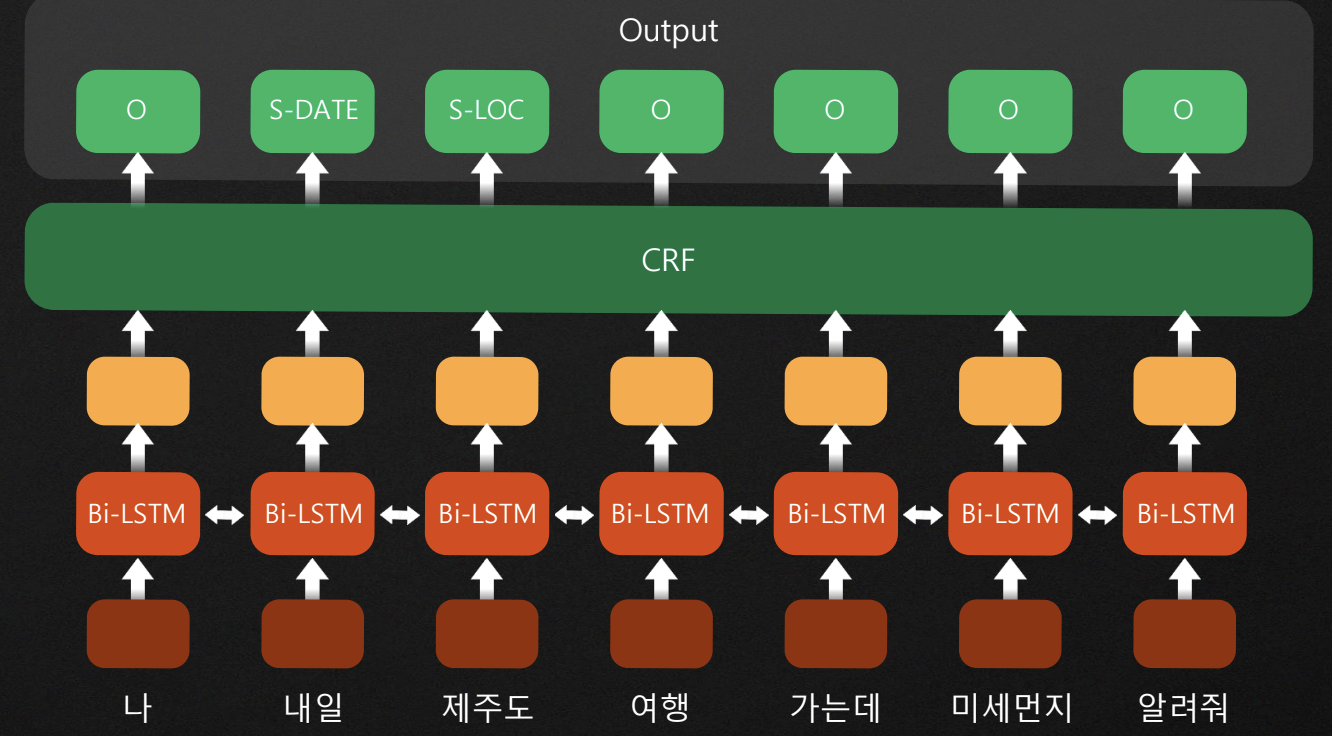

In [9]:
!pip install pytorch-crf
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00


In [10]:
import os
import sys
import json
import torch
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from tqdm import tqdm
from tqdm import trange

'''
pip install pytorch-crf
https://pytorch-crf.readthedocs.io/en/stable/
'''
from torchcrf import CRF

from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader



In [11]:
%cd /content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
from src.dataset import Preprocessing
from src.model import EpochLogger, MakeEmbed, save

%cd /root

/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
/root


## Data Processing
### Entity recognition task를 위한 데이터 처리

In [13]:
'''
 PyTorch의 TensorDataset은 기본적으로 x[index], y[index]를 제공합니다.
 그 외에 추가로 제공하고 싶은게 있으면 아래와 같이 커스텀이 가능합니다.
 여기서는 입력되는 문장의 길이를 제공 받아야해서 아래와 같이 커스텀을 하였습니다.
'''
class EntityDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor, lengths):
        super(EntityDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor
        self.lengths = lengths

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.lengths[index]

    def __len__(self):
        return len(self.x)

class MakeDataset:
    def __init__(self):

        self.entity_label_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/entity_label.json"
        self.entity_data_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/dataset/entity_data.csv"

        self.entity_label = self.load_entity_label()
        self.prep = Preprocessing()

    def load_entity_label(self):
        f = open(self.entity_label_dir, encoding="UTF-8")
        entity_label = json.loads(f.read())
        self.entitys = list(entity_label.keys())
        return entity_label


    def tokenize(self, sentence):
        return sentence.split()

    def tokenize_dataset(self, dataset):
        token_dataset = []
        for data in dataset:
            token_dataset.append(self.tokenize(data))
        return token_dataset

    def make_entity_dataset(self, embed): #
        entity_dataset = pd.read_csv(self.entity_data_dir)
        entity_querys = self.tokenize_dataset(entity_dataset["question"].tolist())
        labels = []
        for label in entity_dataset["label"].to_list():
            temp = []
            for entity in label.split():
                temp.append(self.entity_label[entity])
            labels.append(temp)
        dataset = list(zip(entity_querys, labels))
        entity_train_dataset, entity_test_dataset = self.word2idx_dataset(dataset, embed)
        return entity_train_dataset, entity_test_dataset

    def word2idx_dataset(self, dataset ,embed, train_ratio = 0.8):
        embed_dataset = []
        question_list, label_list, lengths = [], [], []
        flag = True
        random.shuffle(dataset)
        for query, label in dataset :
            q_vec = embed.query2idx(query)
            lengths.append(len(q_vec))

            q_vec = self.prep.pad_idx_sequencing(q_vec)

            question_list.append(torch.tensor([q_vec]))

            label = self.prep.pad_idx_sequencing(label)
            label_list.append(label)
            flag = False


        x = torch.cat(question_list)
        y = torch.tensor(label_list)

        x_len = x.size()[0]
        y_len = y.size()[0]
        if(x_len == y_len):
            train_size = int(x_len*train_ratio)

            train_x = x[:train_size]
            train_y = y[:train_size]

            test_x = x[train_size+1:]
            test_y = y[train_size+1:]

            train_length = lengths[:train_size]
            test_length = lengths[train_size+1:]

            train_dataset = EntityDataset(train_x,train_y,train_length)
            test_dataset = EntityDataset(test_x,test_y,test_length)

            return train_dataset, test_dataset

        else:
            print("ERROR x!=y")

In [14]:
dataset = MakeDataset()
#Inside, Out, Begin, End, Single
#IO :  TAG라면 I 을 아니면 O 로 태그.
#BIO : TAG의 길이가 2이상이면 첫 번째 단어는 B를 붙이고 그 뒤의 단어들은 I를 붙인다.
#BIOES : BIO에서 단어의 길이가 3이상인 단어는 마지막 단어에 E를 붙인다. 그리고 단어의 길이가 1이라면, S를 붙인다.
# S : 단독
# B : 복합의 시작 (단독 사용 불가)
# I : 복합의 중간 (단독 사용 불가)
# E : 복합의 끝  (단독 사용 불가)
# O : 의미 없음
dataset.entity_label

{'O': 0,
 'B-DATE': 1,
 'B-LOCATION': 2,
 'B-PLACE': 3,
 'B-RESTAURANT': 4,
 'E-DATE': 5,
 'E-LOCATION': 6,
 'E-PLACE': 7,
 'E-RESTAURANT': 8,
 'I-DATE': 9,
 'I-RESTAURANT': 10,
 'S-DATE': 11,
 'S-LOCATION': 12,
 'S-PLACE': 13,
 'S-RESTAURANT': 14,
 '<START_TAG>': 15,
 '<STOP_TAG>': 16}

In [15]:
entity_dataset = pd.read_csv(dataset.entity_data_dir)

entity_dataset.head()

,question,label
0,야 먼지 알려주겠니,O O O
1,아니 먼지 정보 알려주세요,O O O O
2,그 때 미세먼지 어떨까,O O O O
3,그 때 먼지 좋으려나,O O O O
4,미세먼지 어떨 것 같은데,O O O O


In [16]:
entity_dataset.groupby(['label']).count()

,question
label,
B-DATE E-DATE B-LOCATION E-LOCATION O O,4
B-DATE E-DATE O,6
B-DATE E-DATE O B-LOCATION E-LOCATION O O O O,1
B-DATE E-DATE O O,42
B-DATE E-DATE O O O,31
...,...
S-RESTAURANT O S-LOCATION O O,4
S-RESTAURANT O S-RESTAURANT O,3
S-RESTAURANT S-LOCATION O,1


## Bidirectional LSTM-CRF Models for Sequence Tagging
### * Zhiheng Huang,Wei Xu,Kai Yu
### tensorflow code : https://github.com/ngoquanghuy99/POS-Tagging-BiLSTM-CRF/blob/main/model.py
### tensorflow, keras code : https://github.com/floydhub/named-entity-recognition-template/blob/master/ner.ipynb

In [17]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, w2v, tag_to_ix, hidden_dim, batch_size):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = w2v.size()[1]
        self.hidden_dim = hidden_dim
        self.vocab_size =  w2v.size()[0]
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.batch_size = batch_size
        self.START_TAG = "<START_TAG>"
        self.STOP_TAG = "<STOP_TAG>"

        self.word_embeds = nn.Embedding(self.vocab_size+2, self.embedding_dim)
        self.word_embeds.weight[2:].data.copy_(w2v)
        #self.word_embeds.weight.requires_grad = False

        # LSTM 파라미터 정의
        # bidirectional : 양방향 LSTM
        # num_layers    : layer의 수
        # batch_first   : pytorch에서 LSTM 입력의 기본값은 (Length,batch,Hidden) 순서 이므로 (batch,Length,Hidden)로 바꿔주기 위함
        # nn.LSTM(input_size, hidden_size, batch_first, num_layers)
        # hidden_size = hidden_dim // 2 인 이유는 bidirectional = True 이기 떄문이다.
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim // 2, batch_first=True, num_layers=1, bidirectional=True)

        # LSTM의 출력을 태그 공간으로 매핑하기 위해
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.hidden = self.init_hidden()

        # 출력층의 규칙학습을 위한 CRF 세팅
        self.crf = CRF(self.tagset_size, batch_first=True)

    def init_hidden(self):#(h,c)
        return (torch.randn(2, self.batch_size, self.hidden_dim // 2),
                torch.randn(2, self.batch_size, self.hidden_dim // 2))

    def forward(self, sentence):
        # Bi-LSTM으로부터 배출 점수를 얻습니다.
        self.batch_size = sentence.size()[0]
        self.hidden = self.init_hidden()
        #(2,128,128),(2,128,128)
        embeds = self.word_embeds(sentence)
        #(128,20,300)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        #(128,20,256),((2,128,128),(2,128,128))
        lstm_feats = self.hidden2tag(lstm_out)#(batch, length,tagset_size)
        #(128,20,17)
        return lstm_feats

    def decode(self, logits, mask):
        """
        Viterbi Decoding의 구현체입니다.
        CRF 레이어의 출력을 prediction으로 변형합니다.
        :param logits: 모델의 출력 (로짓)
        :param mask: 마스킹 벡터
        :return: 모델의 예측 (prediction)

        각 단어의 자리마다
          word 1의 태그 확률        |  word2의 태그 확률
         'O': 확률0,              | 'O': 확률A,
         'B-DATE': 확률1,         | 'B-DATE': 확률B
         'B-LOCATION': 확률2,     | 'B-LOCATION': 확률C,
         'B-PLACE': 확률3,        | 'B-PLACE': 확률D,
         'B-RESTAURANT': 확률4,   | 'B-RESTAURANT': 확률E,
         'E-DATE': 확률5,         | 'E-DATE': 확률F,
         'E-LOCATION': 확률6,     | 'E-LOCATION': 확률G,
         'E-PLACE': 확률7,        | 'E-PLACE': 확률H,
         'E-RESTAURANT': 확률8,   | 'E-RESTAURANT': 확률I,
         'I-DATE': 확률9,         | 'I-DATE': 확률J,
         'I-RESTAURANT': 확률10,  | 'I-RESTAURANT': 확률K,
         'S-DATE': 확률11,        | 'S-DATE': 확률L,
         'S-LOCATION': 확률12,    | 'S-LOCATION': 확률M,
         'S-PLACE': 확률13,       | 'S-PLACE': 확률N,
         'S-RESTAURANT': 확률14,  | 'S-RESTAURANT': 확률O,
         '<START_TAG>': 확률15,   | '<START_TAG>': 확률P,
         '<STOP_TAG>': 확률15,    | '<STOP_TAG>': 확률Q,

         각각의 높은 확률을 뽑는 것은 보통의 딥러닝 방식으로 B단독이나 I단독, E단독같은 문제를 야기할 수 있습니다.
         태그들의 확률 값을 받아서
         CRF는 태그들의 의존성을 학습할수 있어서 태그 시퀀스의 확률이 가장 높은 확률을 가지는 예측 시퀀스를 선택한다.
         그래서 B단독이나 I단독, E단독과 같은 문제를 없애줍니다.
         예를 들어 B-DATE, O 와 같은걸 출력하지 않습니다. (CRF는 S-DATE, O 라고 출력합니다.)
        """

        return self.crf.decode(logits, mask)

    def compute_loss(self, label, logits, mask):
        """
        학습을 위한 total loss를 계산합니다.
        :param label: label
        :param logits: logits
        :param mask: mask vector
        :return: total loss
        """

        log_likelihood = self.crf(logits, label, mask=mask, reduction='mean')
        return - log_likelihood  # Negative log likelihood loss



In [18]:
embed = MakeEmbed()
embed.load_word2vec()

entity_train_dataset, entity_test_dataset = dataset.make_entity_dataset(embed)

train_dataloader = DataLoader(entity_train_dataset, batch_size=128, shuffle=True)

test_dataloader = DataLoader(entity_test_dataset, batch_size=128, shuffle=True)

In [19]:
entity_train_dataset.x

tensor([[316,  66,  10,  ...,   0,   0,   0],
        [359,  21,   2,  ...,   0,   0,   0],
        [  8, 135, 182,  ...,   0,   0,   0],
        ...,
        [ 21, 583,   0,  ...,   0,   0,   0],
        [ 94,   9, 159,  ...,   0,   0,   0],
        [ 79,  69,  57,  ...,   0,   0,   0]])

In [20]:
entity_train_dataset.y

tensor([[12,  0,  0,  ...,  0,  0,  0],
        [12,  0,  0,  ...,  0,  0,  0],
        [ 2,  6, 14,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [12,  0, 13,  ...,  0,  0,  0],
        [12,  0,  0,  ...,  0,  0,  0]])

In [21]:
weights = embed.word2vec.wv.vectors
weights = torch.FloatTensor(weights)

model = BiLSTM_CRF(weights, dataset.entity_label, 256, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

BiLSTM_CRF(
  (word_embeds): Embedding(1481, 300)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=17, bias=True)
  (crf): CRF(num_tags=17)
)

## Training

In [22]:
epoch = 5
prev_acc = 0
save_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/1_entity_recog_model/"
save_prefix = "entity_recog"
for i in range(epoch):
    steps = 0
    model.train()
    #for data in train_dataloader:
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {i}")
            x = data[0]
            y = data[1]
            length = data[2]

            logits = model.forward(x)
            # padding 된 부분을 마스킹하기위한 코드
            # 우리는 length값이 존재하여 length값을 이용해서 마스크를 생성해도 가능
            # 하지만 코드 간략화를 위해 pytorch에 where 함수를 이용해 마스크 생성
            # torch.where 함수 설명 : https://runebook.dev/ko/docs/pytorch/generated/torch.where
            mask = torch.where(x > 0, torch.tensor([1.]), torch.tensor([0.])).type(torch.uint8)
            loss = model.compute_loss(y,logits,mask)

            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

    model.eval()
    steps = 0
    accuarcy_list = []
    #for data in test_dataloader:
    with tqdm(test_dataloader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {i}")
            x = data[0]
            y = data[1]
            length = data[2]

            mask = torch.where(x > 0, torch.tensor([1.]), torch.tensor([0.])).type(torch.uint8)
            logits = model.forward(x)

            predicts = model.decode(logits,mask)
            # decode함수를 통해 정확도 계산
            corrects = []
            for target, leng, predict in zip(y, length, predicts):
                corrects.append(target[:leng].tolist() == predict)

            accuracy = 100.0 * sum(corrects)/len(corrects)
            accuarcy_list.append(accuracy)

            loss = model.compute_loss(y,logits,mask)
            tepoch.set_postfix(loss=loss.item(), accuracy= sum(accuarcy_list)/len(accuarcy_list))

        acc = sum(accuarcy_list)/len(accuarcy_list)
        if(acc>prev_acc):
            prev_acc = acc
            save(model, save_dir, save_prefix+"_"+str(round(acc,3)), i)

Epoch 0:   0%|          | 0/125 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
Epoch 1:  23%|██▎       | 29/125 [00:38<02:07,  1.33s/batch, loss=1.47]


KeyboardInterrupt: ignored

## Load & test

In [23]:
model.load_state_dict(torch.load("/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_entity_recog_model/entity_recog_97.192_steps_7.pt"))

model.eval()

BiLSTM_CRF(
  (word_embeds): Embedding(1481, 300)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=17, bias=True)
  (crf): CRF(num_tags=17)
)

In [24]:
%%time
q = "이번 주 날씨"
x = dataset.prep.pad_idx_sequencing(embed.query2idx(dataset.tokenize(q)))

x = torch.tensor(x)
f = model(x.unsqueeze(0))

mask = torch.where(x > 0, torch.tensor([1.]), torch.tensor([0.])).type(torch.uint8)

predict = model.decode(f,mask.view(1,-1))

# S : 단독
# B : 복합의 시작
# I : 복합의 중간
# E : 복합의 끝
tag = [dataset.entitys[p] for p in predict[0]]
for i, j in zip(q.split(' '),tag):
    print("단어 : "+i+" , "+"태그 : "+j)

단어 : 이번 , 태그 : B-DATE
단어 : 주 , 태그 : E-DATE
단어 : 날씨 , 태그 : O
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 29.3 ms


In [25]:
%%time
q = "나 내일 제주도 여행 가는데 미세먼지 알려줘"
x = dataset.prep.pad_idx_sequencing(embed.query2idx(dataset.tokenize(q)))

x = torch.tensor(x)
f = model(x.unsqueeze(0))

mask = torch.where(x > 0, torch.tensor([1.]), torch.tensor([0.])).type(torch.uint8)

predict = model.decode(f,mask.view(1,-1))

# S : 단독
# B : 복합의 시작
# I : 복합의 중간
# E : 복합의 끝
tag = [dataset.entitys[p] for p in predict[0]]
for i, j in zip(q.split(' '),tag):
    print("단어 : "+i+" , "+"태그 : "+j)

단어 : 나 , 태그 : O
단어 : 내일 , 태그 : S-DATE
단어 : 제주도 , 태그 : S-LOCATION
단어 : 여행 , 태그 : O
단어 : 가는데 , 태그 : O
단어 : 미세먼지 , 태그 : O
단어 : 알려줘 , 태그 : O
CPU times: user 10.9 ms, sys: 901 µs, total: 11.8 ms
Wall time: 28.1 ms
